# Student side

Our student wishes to get trained in recognizing MNIST images, it's ready to pay upto 1000 DOPA wei tokens for getting it's accuracy to 100%. It requires every teacher to pay 20 DOPA weis for teaching it, and plans to chrage 10 DOPA weis for every classification it later does.

## About MNIST
[MNIST](href='https://en.wikipedia.org/wiki/MNIST_database') is a large database of handwritten digits that is commonly used for training various image processing systems. Below are the first 8 test figures in this database:

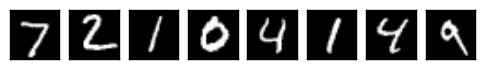

In [1]:
import matplotlib.pyplot as plt
from mnist import MnistData

mnist_data = MnistData(0,0)
fig = plt.figure(1)
subplot_num = 180
for i in range(8):
    subplot_num += 1
    plt.subplot(subplot_num)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mnist_data.x_test[i].reshape([28,28]), cmap='gray')
plt.show()


## About Teacher Reward Calculators

In this sample we used a <I> LogarithmicTeacherReward </I> calculator (available in the Dopamine library), which means that the teachers would be rewarded on a logarithmic scale according to their contribution for raising the student's score. where the teacher/s that helped bringing the students scroe
from 99% to 100% get half of the total reward (500). Code below plots the cumulative reward per achieved score:

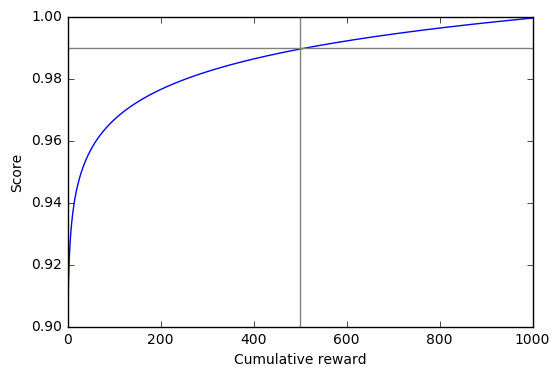

In [2]:
from dopapy.utils.calculators.reward.teacher import LogarithmicTeacherReward
ltr = LogarithmicTeacherReward(min_score=0.0, mid_score=0.99, max_score=1.0, reward_sum=1000)
x = []
y = []
bins = 1000
cumulative_reward = 0
for i in range(0,bins,1):
    from_score = 1.0/bins*i
    to_score = from_score+1.0/bins
    cumulative_reward += ltr.get_reward(from_score,to_score)
    y += [cumulative_reward]
    x += [(from_score+to_score)*0.5]
plt.figure()
plt.plot(y, x)
plt.xlim((0,1000))
plt.ylim((0.9,1.0))
plt.axvline(x=500, color='grey')
plt.axhline(y=0.99, color='grey')
plt.xlabel('Cumulative reward')
plt.ylabel('Score')
plt.show()

## Our Student

Our Student is a learning service based on labels, which means it needs to derive Dopamine's LabeledLearningServiceInstanceBase class and implement some abstract methods. Basically, the code below does that while wrapping the Deep Learning model which is coded in [DigitClassifier](digit_classifier.py):

In [3]:
from digit_classifier import DigitClassifier
from dopapy.core.services.instance.base.learning import LabeledLearningServiceInstanceBase


class Student(LabeledLearningServiceInstanceBase):
    def __init__(self):
        super().__init__()
        self.digit_classifier = DigitClassifier()
        self.digit_classifier.build_graph()
        self.reward_calculator = ltr
        self.rewards_given=[]
        self.score_reached=[]
        self.total_rewards_given=0
        
    def train(self, update, return_gradient, data, labels):
        if return_gradient:
            raise InvalidArgumentException('return_gradient not supported')
        elif not update:
            raise InvalidArgumentException('not updating not supported')
        else:
            x_train, y_train = data[0], labels[0]
            print('Starting a training session...')
            score_before, score_after = self.digit_classifier.train_and_return_accuracy_change(x_train.data, y_train.data)        
            print('Score_before: {0}, score_after:{1}'.format(score_before[1], score_after[1]))
            reward = int(self.reward_calculator.get_reward(from_score=score_before[1], to_score=score_after[1]))
            print('Reward:',reward)
            context=next (iter (quote.get_context_data_collection()[dt.ServiceDescriptor.DEFAULT_SERVICE_INSTANCE_ID].values()))
            destination_account=context.counter_account_address
            print('destination_account:',destination_account)
            session.send_dopamine(amount=reward,destination_account=destination_account,min_gas_price=1000)
            print('Reward sent:{0}'.format(reward))
            self.total_rewards_given=self.total_rewards_given+reward
            self.rewards_given+=[self.total_rewards_given]
            self.score_reached+=[score_after[1]]
            return y_train

    def predict(self, data):
        return dd.Tensor(self.digit_classifier.predict(data.data))

    def save_in_file(self, file_name):
        self.digit_classifier.save_in_file(file_name)

    def load_from_file(self, file_name):
        self.digit_classifier.load_from_file(file_name)


## Student Instance Creators

In our example all teachers are training <B><U> the same </B></U> student, that's taken care of in the following class. In future examples we will show use cases where every client works with it's own instance:

In [4]:
import dopapy
import dopapy.trading as dp
import dopapy.types as dt
from dopapy.utils.common.guid import GUID
from dopapy.core.services.instance.iservice import IServiceInstance, ILabeledLearningServiceInstance
from dopapy.core.services.instance.creator.icreator import IServiceInstanceCreator

class StudentInstanceCreator(IServiceInstanceCreator):
    def __init__(self):
        self.shared_instance = None
    def create_instance(self, service_instance_id: GUID):
        if service_instance_id == dt.ServiceDescriptor.DEFAULT_SERVICE_INSTANCE_ID:
            if self.shared_instance is None:
                self.shared_instance = Student()
            return self.shared_instance
        else:
            raise InvalidArgumentException("This service does not support unique (non zero) instances")

# Plugging the Student onto the Dopamine Network

In [5]:
dopapy.init_logging()
import warnings
warnings.filterwarnings('ignore') #Thats just to ignore warnings that are irrelevant for this type of sample

session = dp.create_session(master_password='password123456',
                            keystore_dir='/data/dopamine/keystore_dir_b/',
                            web_server_host="127.0.0.1",
                            dopmn_budget=10000,  # Allow to spend DOPAs from this account
                            ether_budget=int(10E18),
                            web_server_port=8007)
#Check balance:
print('DOPA Balance:',session.wallet.dopmn_balance)
print('ETH  Balance:',session.wallet.ether_balance)

my_service_descriptor = dt.ServiceDescriptor(
    service_role=dt.ServiceRole.PROVIDER,
    input_descriptors=[dt.TensorDescriptor([-1,28,28,1])],
    output_descriptors=[dt.TensorDescriptor([-1])],
    service_type=dt.ServiceType.Learning.LABELED
)

student_reward_desc = dp.create_reward_descriptor(min_dopamine_price=10)
student_reward_desc.add_payment(dt.RewardPaymentType.UPDATE, min_price=20)
student_reward_desc.add_payment(dt.RewardPaymentType.FORWARD, min_price=0)

my_student_instance_creator = StudentInstanceCreator()
quote = dp.create_quote_services(
    service_instance_creator = my_student_instance_creator,
    session=session,
    service_descriptor=my_service_descriptor,
    side=dp.SELL,
    reward_descriptor=student_reward_desc)

quote.publish()

DOPA Balance: 1000000000006938
ETH  Balance: 9309397200000000000
Starting a training session...
Score_before: 0.1397, score_after:0.9706
Reward: 127
destination_account: 0x35eee7ce8a2f0d41604bf9ea6679d39b5ff18592
Reward sent:127
Starting a training session...


### Here student needs to wait for the teachers to do their work...

<img src='../img/waiting.png'>

## Analyzing the teaching process

### Checking balance:

In [6]:
print('DOPA Balance:',session.wallet.dopmn_balance)
print('ETH  Balance:',session.wallet.ether_balance)

DOPA Balance: 1000000000012929
ETH  Balance: 10000000000000000000


### Contribution vs Reward per Teacher

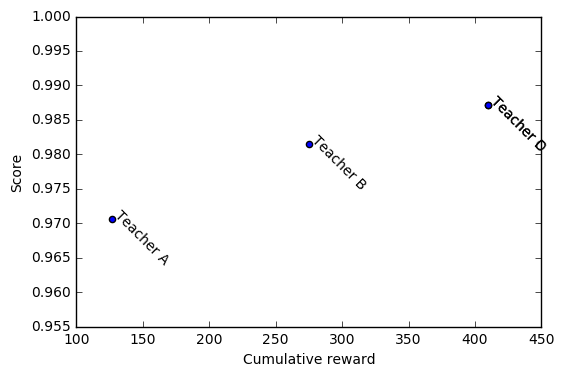

In [8]:
student = my_student_instance_creator.shared_instance
names = ['Teacher A','Teacher B','Teacher C','Teacher D']        
plt.figure()
fig, ax = plt.subplots()
ax.scatter(student.rewards_given, student.score_reached)
plt.xlabel('Cumulative reward')
plt.ylabel('Score')
for i, txt in enumerate(names):
    ax.annotate(txt, (student.rewards_given[i],student.score_reached[i]), rotation=-45)
plt.show()  